# Iterative method of Siqueira et al. (2017) - $\mathtt{SOB17}$

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import constants as cts

### Data points

In [2]:
with open('data_points.pickle', 'rb') as f:
    data_points = pickle.load(f)

In [3]:
# number of points along x and y
print(data_points['shape'])

# minimum x, maximum x, minimum y and maximum y
print(data_points['area'])

(50, 50)
[-5000, 5000, -4000, 6000]


In [4]:
# Grid spacing
dx = (data_points['area'][1] - data_points['area'][0])/(data_points['shape'][0]-1)
dy = (data_points['area'][3] - data_points['area'][2])/(data_points['shape'][1]-1)

In [5]:
dx, dy

(204.08163265306123, 204.08163265306123)

In [6]:
# total number of data
D = np.prod(data_points['shape'])

In [7]:
D

2500

In [8]:
data_points['coordinates'][2,0]

-100.0

### Noise-corrupted gravity data

In [9]:
with open('gravity_data_noisy.pickle', 'rb') as f:
    gravity_data_noisy = pickle.load(f)

### Set the equivalent sources location

In [10]:
# depth of the equivalent layer
Delta_z = 3*dx
z_layer = data_points['coordinates'][2,0] + Delta_z

In [11]:
Delta_z, z_layer

(612.2448979591837, 512.2448979591837)

In [12]:
data_points['coordinates'][2,0]

-100.0

### Compute the sensitivity matrix

In [13]:
# kernel matrix associated with the equivalent layer
G = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
    eql.kernel_matrix_monopoles(data_points['coordinates'], z_layer, field="z", first_column=False)
)

In [14]:
G.shape

(2500, 2500)

In [15]:
# factor controlling convergence
#sigma = (dx*dy)/(2*np.pi*cts.GRAVITATIONAL_CONST*cts.SI2MGAL)
sigma = 100/np.trace(G)

In [16]:
sigma

2246928308.569167

### Estimate the physical-property distribution

In [17]:
# physical-property distribution
convergence, parameters = eql.method_iterative_SOB17(
    G=G, data=gravity_data_noisy['d20'], factor=sigma, epsilon=1e-3, ITMAX=50, check_input=True
    )

In [18]:
iterations = [i for i in range(len(convergence))]

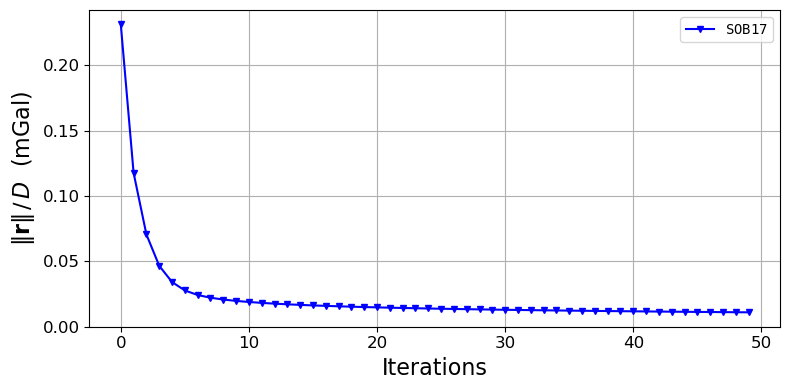

In [19]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='blue', marker='v', alpha=1, markersize=4, label='$\mathtt{SOB17}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
#plt.savefig('../manuscript/Fig/convergence_TOB20.png', dpi= 300)
plt.show()

In [20]:
# data predicted by the estimated equivalent layer
predicted_data = G@parameters

In [21]:
# residuals vector
residuals = predicted_data - gravity_data_noisy['d20']

### Plot the data fit

In [22]:
ranges_data = np.max(np.abs(gravity_data_noisy['d20']))
ranges_res = np.max(np.abs(residuals))

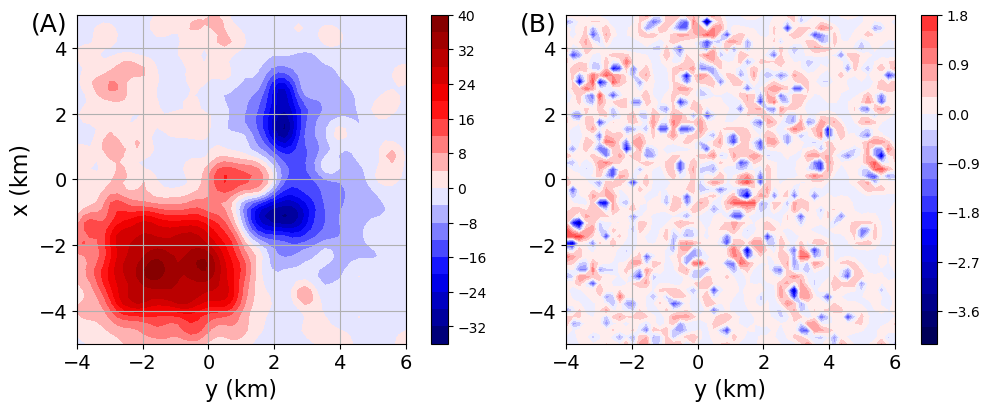

In [23]:
fig = plt.figure(layout= 'constrained', figsize=(10,4))
mosaic = fig.subplot_mosaic('''
                            ab
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 predicted_data.reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_data, vmax=ranges_data)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(A)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

ax = mosaic['b']
ax.axis('scaled')
im = ax.contourf(data_points['coordinates'][1].reshape(data_points['shape'])*0.001, 
                 data_points['coordinates'][0].reshape(data_points['shape'])*0.001, 
                 residuals.reshape(data_points['shape']), 20, 
                 cmap='seismic', vmin=-ranges_res, vmax=ranges_res)
fig.colorbar(im, ax=ax)
ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
ax.annotate('(B)', xy=(-0.14, 0.95), xycoords='axes fraction', fontsize=18)
#mosaic['b'].set_ylabel('x (km)', fontsize=16)
mosaic['b'].set_xlabel('y (km)', fontsize=16)

plt.show()